In [2]:
import os
import glob
import json
import h5py
import optparse
import sys
import traceback
import copy
import re

import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
import scipy.stats as spstats
import statsmodels as sm
import cPickle as pkl
import tifffile as tf

import numpy as np
from scipy.optimize import leastsq
import pylab as pl


from pipeline.python import utils as putils
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import experiment_classes as util

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fi

In [3]:
%matplotlib notebook

In [5]:
rootdir = '/n/coxfs01/2p-data'

#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)


In [6]:
#### Set output dir
outdir = os.path.join(aggregate_dir, 'quality-checks', 'area-assignment')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/quality-checks/area-assignment


In [7]:
fov_keys = aggr.get_sorted_fovs()

In [9]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [10]:
pp.pprint(fov_keys)

{   'JC076': {   'Li': [('20190422_fov1', '20190502_fov1')],
                 'Lm': ['20190423_fov1'],
                 'V1': [('20190420_fov1', '20190501_fov1')]},
    'JC078': {   'Lm': [   ('20190426', '20190504', '20190509'),
                           ('20190430', '20190513')]},
    'JC080': {   'Li': ['20190602_fov1'],
                 'Lm': [('20190506', '20190603'), '20190602_fov2']},
    'JC083': {   'Lm': [('20190508', '201905012', '20190517')],
                 'V1': [('20190507', '20190510', '2010511')]},
    'JC084': {   'Lm': ['20190525'], 'V1': ['20190522']},
    'JC085': {   'V1': ['20190622']},
    'JC089': {   'Li': ['20190522']},
    'JC090': {   'Li': ['20190605']},
    'JC091': {   'Li': [   ('20190602', '20190607'),
                           ('20190606', '20190614'),
                           ('20191007', '20191008')],
                 'Lm': ['20190627']},
    'JC092': {   'Li': ['20190527_fov2', '20190527_fov3', '20190528']},
    'JC097': {   'Lm': ['20190615_f

In [19]:
import tifffile as tf
import cv2

In [40]:
animalid = 'JC080'
session = '20190603'
fov = 'FOV1_zoom2p0x'
channel_id = 2
anat_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, 'anatomical', \
                                    'anatomical_Channel%02d*.tif' % channel_id))[0]
anat_fpath

'/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/anatomical/anatomical_Channel02_transformed.tif'

In [54]:
img = cv2.imread(anat_fpath)
# img = tf.imread(anat_fpath)

print(img.dtype, img.min(), img.max())
print(img.shape)


(dtype('uint8'), 0, 255)
(512, 512, 3)


In [55]:
if len(img.shape)>2:
    img = img[:, :, 0]
img.shape

(512, 512)

In [66]:
print("top2bottom:", 0.302*8.0)
print("left2right", 0.289*8.0)



('top2bottom:', 2.416)
('left2right', 2.312)


In [67]:
26.015 - 25.8941

0.1208999999999989

In [72]:
0.236*8.0

1.888

In [78]:
cv2.resize?

In [74]:
xaxis_conversion = 2.31 #2.312 # goes with A-P axis
yaxis_conversion = 1.89  #1.904 # goes with M-L axis

In [82]:
d1, d2 = img.shape # (im_h, im_w)
new_d1 = int(round(d1*xaxis_conversion, 1)) # after transform, 
new_d2 = int(round(d2*yaxis_conversion, 1)) # after transform, d2~ML axis (width), 
zimg_r = cv2.resize(im, (new_d2, new_d1))   # (new_d1~COLS, new_d2~ROWS)
print(zimg_r.shape)
print(new_d1, new_d2)

(1182, 967)
(1182, 967)


In [83]:
img.size

262144

<IPython.core.display.Javascript object>


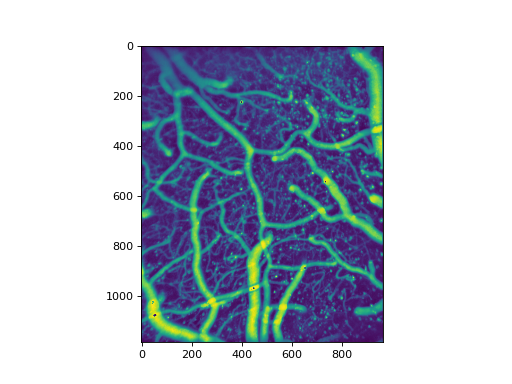

In [84]:
pl.figure()
pl.imshow(zimg_r)

In [60]:
img_outpath = '%s_scaled2.png' % os.path.splitext(anat_fpath)[0]

cv2.imwrite(img_outpath, zimg_r)
#tf.imsave(img_outpath, zimg_r)


True

In [63]:
tf.im

AttributeError: 'module' object has no attribute 'im'